In [1]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, MaxPool2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

## Dataset generation

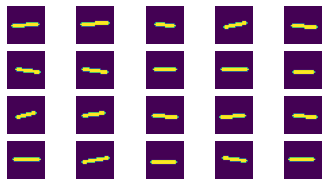

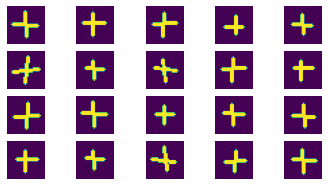

In [2]:
# Create plus/minus signs
def generate_images(cross=False, n=50):
    x = np.random.randint(12, 16, (n, 2))
    y1 = np.random.randint(4, 8, n)
    y2 = np.random.randint(20, 24, n)
    
    blank = np.zeros([n, 28, 28])
    for i in range(n):
        cv2.line(blank[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)
        if cross:
            cv2.line(blank[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank

def show_generated(images):
    for i in range(20):
        plt.subplot(5, 5, i+1)
        plt.axis("off")
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(cross=True))

In [3]:
def create_data(highest_integer):
    """
    Creates the following data for all pairs of integers up to [highest integer]+[highest_integer]:

    @return:
    X_text: '151+ 21' -> text query of an arithmetic operation
    X_img : Stack of MNIST images corresponding to the query (7 x 28 x 28)
    y_text: ' 172' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (4 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(cross=True)
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []
    for i in range(highest_integer + 1):
        for j in range(highest_integer + 1):
            
            i_char = to_padded_chars(i, max_len=max_int_length)
            j_char = to_padded_chars(j, max_len=max_int_length)

            for sign in ['-', '+']:
                query_string = i_char + sign + j_char
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))
            
    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.
  
def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


(80000,) (80000, 7, 28, 28) (80000,) (80000, 4, 28, 28)
Sample ID: 56606

X_text: "141-103" = y_text: "  38"


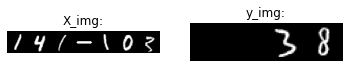

Sample ID: 15812

X_text: " 39-106" = y_text: " -67"


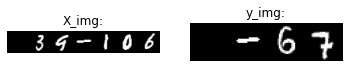

Sample ID: 36038

X_text: " 90- 19" = y_text: "  71"


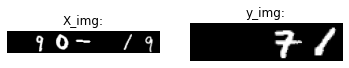

Sample ID: 64062

X_text: "160- 31" = y_text: " 129"


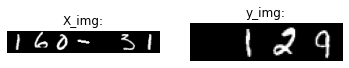

Sample ID: 35284

X_text: " 88- 42" = y_text: "  46"


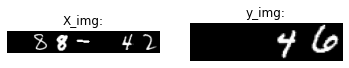

Sample ID: 79820

X_text: "199-110" = y_text: "  89"


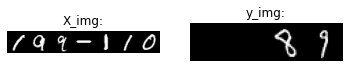

Sample ID: 13155

X_text: " 32+177" = y_text: " 209"


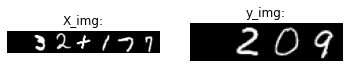

Sample ID: 33013

X_text: " 82+106" = y_text: " 188"


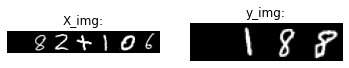

Sample ID: 79801

X_text: "199+100" = y_text: " 299"


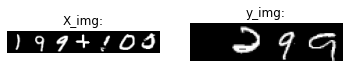

Sample ID: 16597

X_text: " 41+ 98" = y_text: " 139"


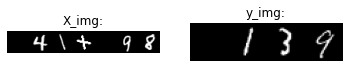

In [4]:
# Illustrate the generated query/answer pairs
unique_characters = '0123456789+- ' # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 199 # Highest value of integers contained in the queries
max_int_length = len(str(highest_integer)) # 
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = max_int_length + 1    # Maximum length of the answer string

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)

print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)

## Display the samples that were created
def display_sample(n):
    labs = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        plt.axis('off')
        plt.title(labs[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nSample ID: {n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 80000, 1)[0])

In [5]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
def encode_labels(labels, max_len=4):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot 

def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])
    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(80000, 7, 13) (80000, 4, 13)


## Text-to-text

In [6]:
text2text = tf.keras.Sequential()
text2text.add(LSTM(256, input_shape=(max_query_length, len(unique_characters))))
text2text.add(RepeatVector(max_answer_length))
text2text.add(LSTM(128, return_sequences=True))
text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
text2text.w_init = text2text.get_weights()
print(text2text.summary(), "\n\n")


text2text_2 = tf.keras.Sequential()
text2text_2.add(GRU(256, input_shape=(max_query_length, len(unique_characters))))
text2text_2.add(RepeatVector(max_answer_length))
text2text_2.add(GRU(128, return_sequences=True))
text2text_2.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
text2text_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
text2text_2.w_init = text2text_2.get_weights()
text2text_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               276480    
                                                                 
 repeat_vector (RepeatVector  (None, 4, 256)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 4, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 4, 13)            1677      
 ibuted)                                                         
                                                                 
Total params: 475,277
Trainable params: 475,277
Non-trainable params: 0
_________________________________________________________________
None 


Model: "sequential_1"
____________________

In [61]:
def show_t2t_train(histories):
    fig, axs = plt.subplots(2,2, figsize=(8, 6))
    for i, history in enumerate(histories):
        test_size = history[1]
        history = history[0]
        j, i = int(i/2), i % 2
        axs[i, j].plot(np.arange(1, len(history.history["accuracy"])+1), history.history["accuracy"], label="Train set")
        axs[i, j].plot(np.arange(1, len(history.history["val_accuracy"])+1), history.history["val_accuracy"], label="Val set")
        axs[i, j].set_title(f"Text to Text training\n({round(1-test_size, 2)} train - {test_size} test)")
        axs[i, j].set(xlabel="Epochs", ylabel="Accuracy")
        axs[i, j].legend()
        axs[i, j].grid()
    fig.tight_layout()

In [25]:
def t2t_train(model, test_sizes):
    histories = []
    for test_size in test_sizes:
        model.set_weights(model.w_init) # reset weights
        X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text_onehot, y_text_onehot, test_size=test_size, shuffle=True)
        if test_size == 0.95:
            early_stop = []
        else:
            early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", min_delta=0.005, patience=10)
        histories.append((model.fit(X_text_train, y_text_train, epochs=100, batch_size=32, validation_split=0.05, callbacks=[early_stop], verbose=0), test_size))
        model.evaluate(X_text_test, y_text_test)
    return histories

In [65]:
histories = t2t_train(text2text, [0.95, 0.90, 0.75, 0.50])

1250/1250 [==============================] - 5s 4ms/step - loss: 0.0032 - accuracy: 0.9997


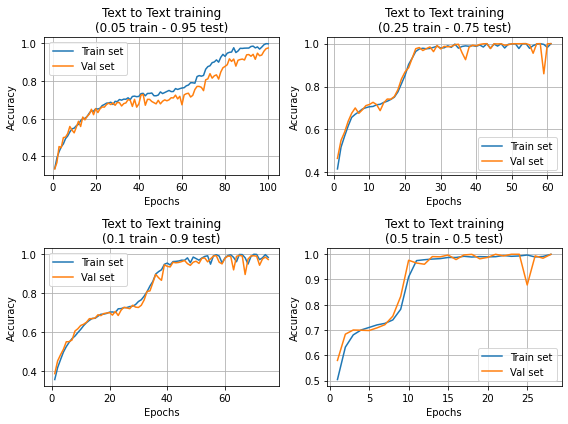

In [66]:
show_t2t_train(histories)

In [67]:
histories_2 = t2t_train(text2text_2, [0.95, 0.90, 0.75, 0.50])

1250/1250 [==============================] - 4s 4ms/step - loss: 0.0147 - accuracy: 0.9958


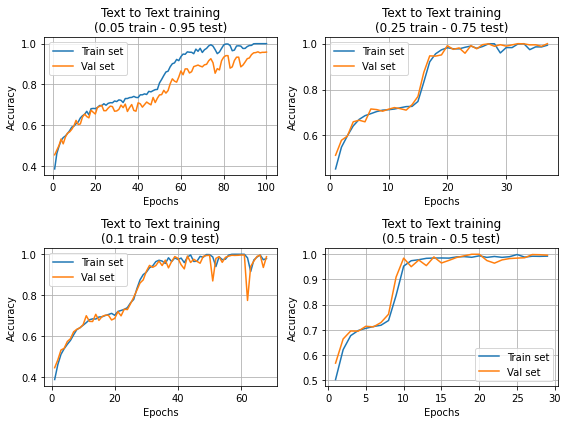

In [68]:
show_t2t_train(histories_2)

## Image-to-Text

In [6]:
image2text = tf.keras.Sequential()
image2text.add(Input(shape=(7, 28, 28, 1)))
image2text.add(TimeDistributed(Conv2D(32, 5, strides=2, activation="relu")))
image2text.add(TimeDistributed(MaxPool2D(2)))
image2text.add(TimeDistributed(Conv2D(64, 3, activation="relu")))
image2text.add(TimeDistributed(MaxPool2D(2)))
image2text.add(TimeDistributed(Flatten()))
image2text.add(LSTM(256))
image2text.add(RepeatVector(max_answer_length))
image2text.add(LSTM(128, return_sequences=True))
image2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
image2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
image2text.w_init = image2text.get_weights()
print(image2text.summary(), "\n\n")

image2text_2 = tf.keras.Sequential()
image2text_2.add(Input(shape=(7, 28, 28, 1)))
image2text_2.add(ConvLSTM2D(16, 5, strides=2, activation="relu", padding="valid", return_sequences=True))
image2text_2.add(ConvLSTM2D(32, 5, strides=1, activation="relu", padding="valid", return_sequences=True))
image2text_2.add(ConvLSTM2D(64, 3, activation="relu", padding="valid"))
image2text_2.add(MaxPool2D(2))
image2text_2.add(Flatten())
image2text_2.add(RepeatVector(max_answer_length))
image2text_2.add(LSTM(128, return_sequences=True))
image2text_2.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
image2text_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
image2text_2.w_init = image2text_2.get_weights()
image2text_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 7, 12, 12, 32)    832       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 7, 6, 6, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 7, 4, 4, 64)      18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 7, 2, 2, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 7, 256)           0

In [7]:
def show_i2t_train(history):
    plt.plot(np.arange(1, len(history.history["accuracy"])+1), history.history["accuracy"], label="Train set")
    plt.plot(np.arange(1, len(history.history["val_accuracy"])+1), history.history["val_accuracy"], label="Val set")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Image to Text training\n(0.3 train - 0.7 test)")
    plt.legend()
    plt.show()

In [8]:
def i2t_train(model):
    model.set_weights(model.w_init) # reset weights
    X_img_train, X_img_test, y_text_train, y_text_test = train_test_split(X_img, y_text_onehot, test_size=0.7, shuffle=True)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", min_delta=0.005, patience=10)
    history = model.fit(X_img_train, y_text_train, epochs=100, batch_size=32, validation_split=0.05, callbacks=[early_stop], verbose=0)
    model.evaluate(X_img_test, y_text_test)
    return history

1750/1750 [==============================] - 8s 4ms/step - loss: 0.2482 - accuracy: 0.9526


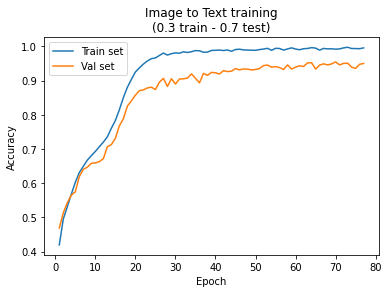

In [9]:
show_i2t_train(i2t_train(image2text))

Epoch 1/100
713/713 [==============================] - 170s 229ms/step - loss: 1.5418 - accuracy: 0.4000 - val_loss: 1.3733 - val_accuracy: 0.4367
Epoch 2/100
713/713 [==============================] - 156s 218ms/step - loss: 1.3473 - accuracy: 0.4473 - val_loss: 1.3293 - val_accuracy: 0.4581
Epoch 3/100
713/713 [==============================] - 150s 210ms/step - loss: 1.3182 - accuracy: 0.4692 - val_loss: 1.2988 - val_accuracy: 0.4758
Epoch 4/100
713/713 [==============================] - 152s 213ms/step - loss: 1.2936 - accuracy: 0.4865 - val_loss: 1.2770 - val_accuracy: 0.4942
Epoch 5/100
713/713 [==============================] - 151s 212ms/step - loss: 1.2687 - accuracy: 0.5012 - val_loss: 1.2661 - val_accuracy: 0.5023
Epoch 6/100
713/713 [==============================] - 152s 213ms/step - loss: 1.2436 - accuracy: 0.5135 - val_loss: 1.2371 - val_accuracy: 0.5179
Epoch 7/100
713/713 [==============================] - 152s 214ms/step - loss: 1.2147 - accuracy: 0.5277 - val_loss: 1

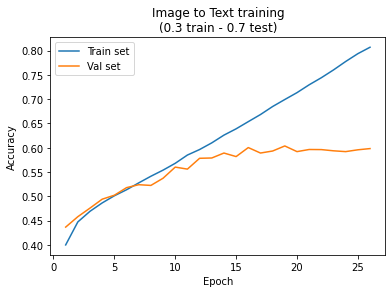

In [21]:
show_i2t_train(i2t_train(image2text_2))

## Text-to-Image

In [29]:
text2image = tf.keras.Sequential()
text2image.add(Input(shape=(max_query_length, len(unique_characters))))
text2image.add(LSTM(128, return_sequences=True))
text2image.add(LSTM(128, return_sequences=True))
text2image.add(LSTM(128))
text2image.add(RepeatVector(4))
text2image.add(LSTM(256, return_sequences=True))
text2image.add(LSTM(256, return_sequences=True))
text2image.add(TimeDistributed(Dense(1024, activation="relu")))
text2image.add(Flatten())
text2image.add(Reshape((64, 8, 8)))
text2image.add(Conv2DTranspose(8, 5, strides=1, data_format="channels_first"))
text2image.add(Conv2DTranspose(4, 6, strides=2, activation="sigmoid", data_format="channels_first"))
text2image.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['mae'])
w_init = text2image.get_weights()
text2image.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_67 (LSTM)              (None, 7, 128)            72704     
                                                                 
 lstm_68 (LSTM)              (None, 7, 128)            131584    
                                                                 
 lstm_69 (LSTM)              (None, 128)               131584    
                                                                 
 repeat_vector_16 (RepeatVec  (None, 4, 128)           0         
 tor)                                                            
                                                                 
 lstm_70 (LSTM)              (None, 4, 256)            394240    
                                                                 
 lstm_71 (LSTM)              (None, 4, 256)            525312    
                                                     

In [9]:
def show_t2i_train(history):
    plt.plot(np.arange(1, len(history.history["loss"])+1), history.history["loss"], label="Train set")
    plt.plot(np.arange(1, len(history.history["val_loss"])+1), history.history["val_loss"], label="Val set")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Text to Image training (0.3 train - 0.7 test)")
    plt.legend()
    plt.show()

In [10]:
X_text_train, X_text_test, y_img_train, y_img_test = train_test_split(X_text_onehot, y_img, test_size=0.7, shuffle=True, random_state=42)

In [30]:
text2image.set_weights(w_init) # reset weights
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", min_delta=0.0001, patience=20)
history = text2image.fit(X_text_train, y_img_train, epochs=100, batch_size=32, validation_split=0.05, callbacks=[early_stop])
text2image.evaluate(X_text_test, y_img_test)

Epoch 1/100
713/713 [==============================] - 18s 17ms/step - loss: 0.2002 - mae: 0.1153 - val_loss: 0.1749 - val_mae: 0.0947
Epoch 2/100
713/713 [==============================] - 13s 18ms/step - loss: 0.1698 - mae: 0.0965 - val_loss: 0.1680 - val_mae: 0.0950
Epoch 3/100
713/713 [==============================] - 13s 18ms/step - loss: 0.1662 - mae: 0.0945 - val_loss: 0.1679 - val_mae: 0.0968
Epoch 4/100
713/713 [==============================] - 13s 18ms/step - loss: 0.1646 - mae: 0.0935 - val_loss: 0.1646 - val_mae: 0.0931
Epoch 5/100
713/713 [==============================] - 12s 17ms/step - loss: 0.1632 - mae: 0.0928 - val_loss: 0.1652 - val_mae: 0.0925
Epoch 6/100
713/713 [==============================] - 13s 18ms/step - loss: 0.1625 - mae: 0.0923 - val_loss: 0.1627 - val_mae: 0.0927
Epoch 7/100
713/713 [==============================] - 13s 18ms/step - loss: 0.1619 - mae: 0.0920 - val_loss: 0.1626 - val_mae: 0.0903
Epoch 8/100
713/713 [==============================] - 

[0.14399674534797668, 0.07824134826660156]

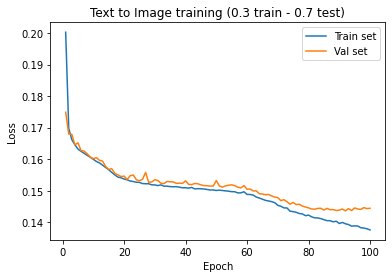

In [32]:
show_t2i_train(history)

136+121 = 257


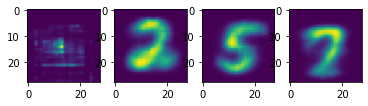

196+ 46 = 242


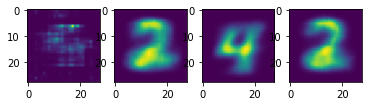

177-181 = -4


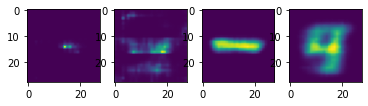

184+ 97 = 281


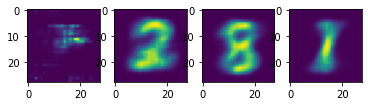

 53+ 42 = 95


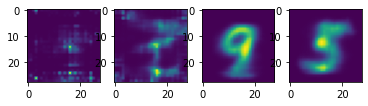

In [53]:
for img_ind in np.random.RandomState(111).randint(0, X_text_train.shape[0], size=5):
    print(decode_labels(X_text_train[img_ind]), "=", eval(decode_labels(X_text_train[img_ind])))
    pred = text2image.predict(X_text_train[img_ind].reshape((1, 7, 13)))
    plt.subplot(1,4,1)
    plt.imshow(pred[0][0])
    plt.subplot(1,4,2)
    plt.imshow(pred[0][1])
    plt.subplot(1,4,3)
    plt.imshow(pred[0][2])
    plt.subplot(1,4,4)
    plt.imshow(pred[0][3])
    plt.show()

179+128 = 307


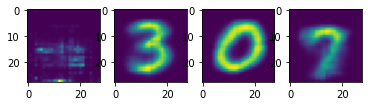

 10-122 = -112


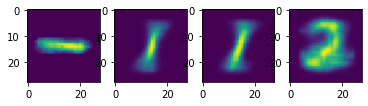

 93+ 98 = 191


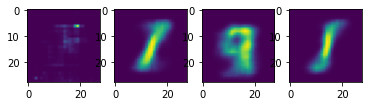

104-187 = -83


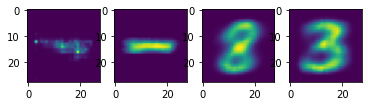

 11-120 = -109


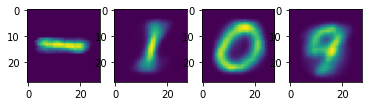

 32+ 84 = 116


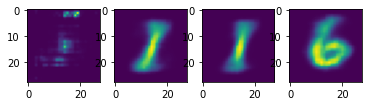

 67+ 72 = 139


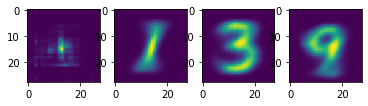

 63+ 40 = 103


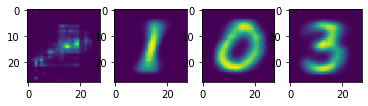

140-115 = 25


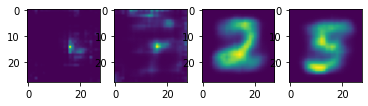

137- 57 = 80


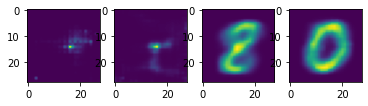

In [39]:
for img_ind in np.random.RandomState(111).randint(0, X_text_test.shape[0], size=10):
    print(decode_labels(X_text_test[img_ind]), "=", eval(decode_labels(X_text_test[img_ind])))
    pred = text2image.predict(X_text_test[img_ind].reshape((1, 7, 13)))
    plt.subplot(1,4,1)
    plt.imshow(pred[0][0])
    plt.subplot(1,4,2)
    plt.imshow(pred[0][1])
    plt.subplot(1,4,3)
    plt.imshow(pred[0][2])
    plt.subplot(1,4,4)
    plt.imshow(pred[0][3])
    plt.show()